In [22]:
# %pylab nbagg
from tvb.simulator.lab import *
import tvb.analyzers.fragility as fragility
from tvb.datatypes.time_series import TimeSeriesSEEG

import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First Run Simulator To Get Test Data

In [2]:
patient = 'id013_pg'
project_dir = '/Users/adam2392/Documents/pydata/metadata/' + patient

In [3]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))
con.speed = np.inf
con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources
# normalize
con.weights = con.weights/np.max(con.weights)
nb_regions = len(con.region_labels)

WARNING  File 'hemispheres' not found in ZIP.


In [4]:
x0ez=-1.6
x0pz=-2.4
x0num=-2.4
period=1.

ezind = 0

coupl = coupling.Difference(a=1.)

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)

print nb_regions

# Integrator
hiss = noise.Additive(nsig = numpy.array([0.001, 0.001, 0., 0.0001, 0.0001, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)


# Epileptor model
epileptors = models.Epileptor(Ks=-2, r=0.0002, tau = 10, tt = 0.07)
epileptors.x0 = -2.4*np.ones(nb_regions)
epileptors.x0[ezind] = -1.6

epileptors.state_variable_range['x1'] = r_[-0.5, 0.1]
epileptors.state_variable_range['z'] = r_[3.5,3.7]
epileptors.state_variable_range['y1'] = r_[-0.1,1]
epileptors.state_variable_range['x2'] = r_[-2.,0.]
epileptors.state_variable_range['y2'] = r_[0.,2.]
epileptors.state_variable_range['g'] = r_[-1.,1.]

# monitors
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(project_dir, "seeg.txt"),
                                   projection_fname=os.path.join(project_dir, "gain_inv-square.txt"),
                                   period=period,
                                   variables_of_interest=[0]
                                   )

num_contacts = mon_SEEG.sensors.labels.size

# run simulation
sim = simulator.Simulator(model=epileptors,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,                          
                          integrator=heunint,
                          monitors=[mon_tavg, mon_SEEG])

sim.configure()

(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000)

# Normalize the time series to have nice plots
tavgn = tavg/(np.max(tavg, 0) - np.min(tavg, 0))
seegn = seeg/(np.max(seeg, 0) - np.min(seeg, 0))
seegn = seegn - np.mean(seegn, 0)

84


In [5]:
# print(ttavg.shape)
print(tavg.shape)
print(seeg.shape)

(10000, 2, 84, 1)
(10000, 1, 59, 1)


# Setup Data to Be Analyzed By Fragility

0. Add randomized line noise if not added with somewhat wide bandwidths (optional)
1. Filter line noise with narrow bands
2. Compute the MVAR models
3. Compute the fragility models

In [6]:
b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
seegf = np.zeros(seegn.shape)
for i in range(num_contacts):
    seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])

In [24]:
chanlabels = mon_SEEG.sensors.labels
print(chanlabels)

['TB1' 'TB2' 'TB3' 'TB4' 'TB5' 'TB6' 'TB7' 'TB8' 'TB9' 'A1' 'A2' 'A3' 'A4'
 'A5' 'A6' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'OT1'
 'OT2' 'OT3' 'OT4' 'OT5' 'OT6' 'OT7' 'OT8' 'OT9' 'C1' 'C2' 'C3' 'C4' 'C5'
 'C6' 'PI1' 'PI2' 'PI3' 'PI4' 'PI5' 'PI6' 'PI7' 'PI8' 'PI9' 'OP1' 'OP2'
 'OP3' 'OP4' 'OP5' 'OP6' 'OP7' 'OP8' 'OP9']


In [8]:
stepsize = 125
winsize = 500
samplerate = 1000.
radius = 1.5

In [9]:
seeg = seeg.squeeze()
ts_seeg = TimeSeriesSEEG(data=seeg.T,
                        sample_period=period)
ts_seeg.configure()
print(ts_seeg.read_data_shape())
print(ts_seeg.data.shape)

(59, 10000)


# Compute Fragility Algo

1. Compute linear models
2. Compute perturbation model for finalized fragility

In [11]:
# initialize models
mvarcomp = fragility.mvarwindowed(timeseries=ts_seeg,
                                  winsize=winsize, 
                                  stepsize=stepsize,
                                  samplerate=samplerate)
mvar_data = mvarcomp.evaluate()
print(mvar_data.shape)

('filtered at: ', array([59.5, 60.5]))
('filtered at: ', array([119.5, 120.5]))
('filtered at: ', array([179.5, 180.5]))
('filtered at: ', array([239.5, 240.5]))
('filtered at: ', array([299.5, 300.5]))
('filtered at: ', array([359.5, 360.5]))
('filtered at: ', array([419.5, 420.5]))
('filtered at: ', array([479.5, 480.5]))
(77, 59, 59)


In [18]:
fragcomp = fragility.fragilitymodel(adjmats=mvarcomp.adjmats,
                                    radius=radius)
frag_data = fragcomp.evaluate()

print(frag_data.shape)

(59, 77)


# Visualize Results

This can visualize the channels activity over time for a range normalized metric for fragility.
Each column represents one more window of time.

Text(0.5,1,u'Fragility Metric Over Time')

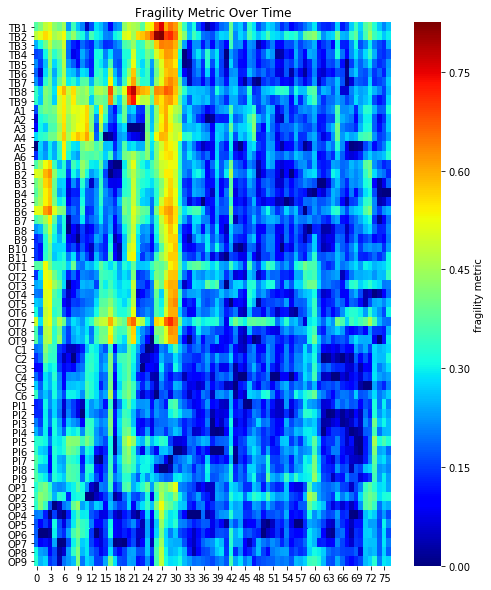

In [34]:
%matplotlib inline
plt.figure(figsize=(8,10))
sns.heatmap(frag_data, yticklabels=chanlabels, cbar_kws={'label': 'fragility metric'}, cmap='jet')
plt.title('Fragility Metric Over Time')